In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np

In [2]:
batch_size = 100
img_sz = 28
img_len = img_sz*img_sz
n_itr = 10000
n_class = 10
lstm_size = 256
T = 10
A = img_sz
B = img_sz
eps = 1e-7
N = 5

In [3]:
# calculate F_x and F_y
def get_Fx_Fy(h):
    params = tf.matmul(h, params_W) + params_b
    g_x_, g_y_, log_var_Fxy, log_delta_, log_gamma = tf.split(1, 5, params)
    var_Fxy = tf.exp(log_var_Fxy)
    gamma = tf.exp(log_gamma)
    
    g_x = ((A + 1) * 0.5) * (g_x_ + 1)
    g_y = ((B + 1) * 0.5) * (g_y_ + 1)
    delta = ((max(A, B) - 1) / (N - 1)) * tf.exp(log_delta_)

    filter_i = tf.reshape(tf.cast(tf.range(N), tf.float32), [1, -1])
    mu_x = g_x + (filter_i - N / 2 - 0.5) * delta
    mu_y = g_y + (filter_i - N / 2 - 0.5) * delta

    a = tf.reshape(tf.cast(tf.range(A), tf.float32), [1, 1, -1])
    b = tf.reshape(tf.cast(tf.range(B), tf.float32), [1, 1, -1])
    mu_x = tf.reshape(mu_x, [-1, N, 1])
    mu_y = tf.reshape(mu_y, [-1, N, 1])
    var_Fxy = tf.reshape(var_Fxy, [-1, 1, 1])    
    
    F_x = tf.exp(-tf.square((a - mu_x) / (2 * var_Fxy)))
    F_y = tf.exp(-tf.square((b - mu_y) / (2 * var_Fxy))) 
    
    F_x = F_x / tf.maximum(tf.reduce_sum(F_x, 2, keep_dims=True), eps)
    F_y = F_y / tf.maximum(tf.reduce_sum(F_y, 2, keep_dims=True), eps)
    return (F_x, F_y, gamma)

In [4]:
def read(r, F_x, F_y, gamma):
    # (F_x.T r F_y) * gamma
    r = tf.reshape(r, [-1, B, A])
    F_x_transpose = tf.transpose(F_x, perm=[0,2,1])
    r = tf.batch_matmul(F_y, tf.batch_matmul(r, F_x_transpose))
    r = tf.reshape(r, [-1, N*N])
    r = r * tf.reshape(gamma,[-1,1])
    return r

In [5]:
def write(w, F_x, F_y, gamma):
    # (F_y.T w_ F_x) / gamma
    w = tf.reshape(w, [batch_size, N, N])
    F_y_transpose = tf.transpose(F_y, perm=[0,2,1])
    w = tf.batch_matmul(F_y_transpose, tf.batch_matmul(w, F_x))
    w = tf.reshape(w, [batch_size, B*A])
    w = w * tf.reshape(1.0/gamma,[-1,1])
    return w

In [6]:
x = tf.placeholder(tf.float32, [batch_size, img_len])
y_ = tf.placeholder(tf.float32, [batch_size, n_class])

rnn_enc = tf.nn.rnn_cell.LSTMCell(lstm_size)
rnn_dec = tf.nn.rnn_cell.LSTMCell(lstm_size)

write_W = tf.Variable(tf.zeros([lstm_size, N*N]))
write_b = tf.Variable(tf.zeros([N*N]))

mu_W = tf.Variable(tf.zeros([lstm_size, n_class]))
mu_b = tf.Variable(tf.zeros([n_class]))


# learnable params for tau
#log_tau_W = tf.Variable(tf.zeros([lstm_size, n_class]))
#log_tau_b = tf.Variable(tf.zeros([n_class]))

params_W = tf.Variable(tf.zeros([lstm_size, 5]))
params_b = tf.Variable(tf.zeros([5]))

lr = tf.placeholder(tf.float32, shape=[])
tau = tf.placeholder(tf.float32, shape=[])

In [7]:
c0 = tf.zeros([batch_size, img_len])
#h0_enc = tf.zeros([batch_size, lstm_size])
h0_dec = tf.zeros([batch_size, lstm_size])

c = [0]*T
#h_enc = h0_enc
h_dec = h0_dec
state_enc = rnn_enc.zero_state(batch_size, tf.float32) 
state_dec = rnn_dec.zero_state(batch_size, tf.float32) 

Lz_list = [0]*T

F_x, F_y, gamma = get_Fx_Fy(h_dec)
# read
for t in range(T):
    c_prev = c0 if t==0 else c[t-1]
    #read
    x_hat = x - tf.sigmoid(c_prev)
    # no atten
    #r = tf.concat(1,[x, x_hat])
    r_x = read(x, F_x, F_y, gamma)
    r_x_hat = read(x_hat, F_x, F_y, gamma)
    r = tf.concat(1,[r_x, r_x_hat])
    
    #encoder
    x_enc = tf.concat(1,[r, h_dec])
    with tf.variable_scope("encoder", reuse=(t != 0)):
        h_enc, state_enc = rnn_enc(x_enc, state_enc)

    # sample Q
    mu_Q = tf.matmul(h_enc, mu_W) + mu_b
    #log_tau_Q = tf.matmul(h_enc, log_tau_W) + log_tau_b
    #tau_Q = tf.exp(log_tau_Q)
    # Gumbol softmax distribution
    U = tf.random_uniform([batch_size, n_class],minval=0,maxval=1)
    # get gumble(0, 1) sample
    # gumble has CDF as -ln(-ln(x))
    # so indexing on CDF using a 
    # sample from uniform distribution 
    # will give the sample form gumble
    G = -tf.log(-tf.log(U + eps) + eps)
    # gubmle(logits, 1) sample
    z_sample = mu_Q + G
    # softmax approximation of one hot (categorical) distrubution
    #z_sfmx = tf.nn.softmax(z_sample / tau_Q)
    z_sfmx = tf.nn.softmax(z_sample / tau)
    
    # get the one hot encoding
    z_one_hot = tf.cast(tf.equal(z_sfmx, tf.reduce_max(z_sfmx, 1, keep_dims=True)), z_sfmx.dtype)
    
    # staright through cat. distr.
    # we need one hot encoding as output (z_one_hot)
    # but gradient on z_sfmx
    diff = tf.stop_gradient(z_one_hot - z_sfmx) 
    # zero gradient flow through this diff varibale 
    # affectively making variable diff a constant
    # so gradient flow through z is same as z_sfmx
    z = diff + z_sfmx
    
    # variational loss
    # KL(Q(z|h_enc)||P(z)) = sum_over(Q(z|h_enc) * log (Q(z|h_enc)/P(z)))
    # prior => P(z) = (1.0 / n_class)
    # Gumbel-Softmax posterior condition on image => Q(z|h_enc) => approximated by z_sfmx
    Lz_list[t] = z_sfmx * (tf.log(z_sfmx + eps) - tf.log(1.0 / n_class))
                 
    # decoder
    with tf.variable_scope("decoder", reuse=(t != 0)):
        h_dec, state_dec = rnn_dec(z, state_dec) 
    
    # no atten
    w = tf.matmul(h_dec, write_W) + write_b
        
    #write       
    F_x, F_y, gamma = get_Fx_Fy(h_dec)
    w = write(w, F_x, F_y, gamma)
                 
    c[t] = c_prev + w

In [8]:
# reconstruction loss
x_recons = tf.sigmoid(c[-1])
# binary cross entropy
Lx = tf.reduce_sum((x * tf.log(x_recons + eps) + (1.0 - x) * tf.log(1.0 - x_recons + eps)), 1)
Lx = -tf.reduce_mean(Lx)

#KL divergence
Lz = tf.add_n(Lz_list)
Lz = tf.reduce_mean(Lz)

In [9]:
loss = Lx + Lz
optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5)
grads_and_vars = optimizer.compute_gradients(loss)
capped_grads_and_vars = [(tf.clip_by_norm(grad, 5.), var) 
                         if grad is not None else (grad, var) 
                         for grad, var in grads_and_vars]
train_step = optimizer.apply_gradients(capped_grads_and_vars)

In [10]:
sess = tf.InteractiveSession()

saver = tf.train.Saver()
tf.global_variables_initializer().run()
recon_loss = np.zeros(n_itr)
variation_loss = np.zeros(n_itr)

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
tau0 = 1.0
tau_val = tau0
anneal_rate = 0.00003
min_temp = 0.5
lr_val = 1e-3 
for i in range(n_itr):
    batch_xs, _ = mnist.train.next_batch(batch_size)
    recon_loss[i], variation_loss[i], _= sess.run([Lx, Lz, train_step], 
                                                  feed_dict={x: batch_xs, 
                                                             tau:tau_val, 
                                                             lr:lr_val})
    
    if i%100==0:
        print("iter=%d : Lx: %f Lz: %f" % (i,recon_loss[i], variation_loss[i]))
    if i % 1000 == 1:
        tau_val = np.maximum(tau0 * np.exp(-anneal_rate*i),min_temp)
        tau_val *= 0.9

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
iter=0 : Lx: 543.427734 Lz: 0.733037
iter=100 : Lx: 207.313553 Lz: 0.869350
iter=200 : Lx: 209.067719 Lz: 0.856327
iter=300 : Lx: 217.610504 Lz: 1.111767
iter=400 : Lx: 209.350540 Lz: 1.040517
iter=500 : Lx: 217.151566 Lz: 1.131096
iter=600 : Lx: 205.552734 Lz: 1.086313
iter=700 : Lx: 206.657974 Lz: 1.077769
iter=800 : Lx: 215.206528 Lz: 1.072048
iter=900 : Lx: 206.135193 Lz: 1.079056
iter=1000 : Lx: 215.061951 Lz: 1.107232
iter=1100 : Lx: 214.734848 Lz: 1.163437
iter=1200 : Lx: 211.560562 Lz: 1.165584
iter=1300 : Lx: 198.121048 Lz: 1.119144
iter=1400 : Lx: 197.066483 Lz: 1.130962
iter=1500 : Lx: 198.936081 Lz: 1.154185
iter=1600 : Lx: 200.543320 Lz: 1.165327
iter=1700 : Lx: 202.816681 Lz: 1.206549
iter=1800 : Lx: 217.872116 Lz: 1.200341
iter=1900 : Lx: 221.362778 Lz: 1.258978
iter=2000 : Lx: 19

In [12]:
batch_xs, _ = mnist.train.next_batch(batch_size)
output_images = sess.run(c, feed_dict={x: batch_xs, tau:tau_val, lr:lr_val}) 
output_images = np.array(output_images) 

out_file="draw_data_gambol_sfmx.npy"
np.save(out_file,[output_images, recon_loss, variation_loss])
print("Outputs saved in file: %s" % out_file)

ckpt_file= "saved_models/draw_model_gambol_sfmx.ckpt"
print("Model saved in file: %s" % saver.save(sess, ckpt_file))

sess.close()

Outputs saved in file: draw_data_gambol_sfmx.npy
Model saved in file: saved_models/draw_model_gambol_sfmx.ckpt


In [13]:
import matplotlib
import sys
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

def xrecons_grid(X,B,A):
    padsize=1
    padval=.5
    ph=B+2*padsize
    pw=A+2*padsize
    batch_size=X.shape[0]
    N=int(np.sqrt(batch_size))
    X=X.reshape((N,N,B,A))
    img=np.ones((N*ph,N*pw))*padval
    for i in range(N):
        for j in range(N):
            startr=i*ph+padsize
            endr=startr+B
            startc=j*pw+padsize
            endc=startc+A
            img[startr:endr,startc:endc]=X[i,j,:,:]
    return img

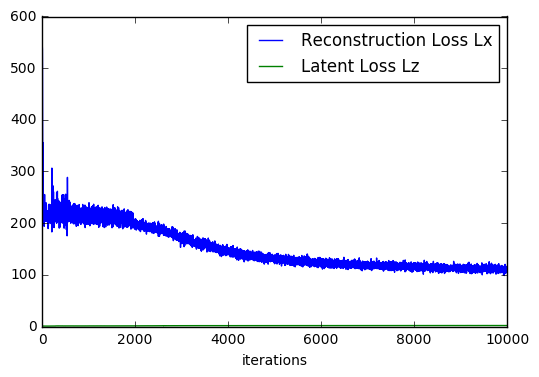

In [14]:
out_file="draw_data_gambol_sfmx.npy"
[C,Lxs,Lzs]=np.load(out_file)
T,batch_size,img_size=C.shape
X=1.0/(1.0+np.exp(-C)) 
B=A=int(np.sqrt(img_size))

plt.plot(Lxs,label='Reconstruction Loss Lx')
plt.plot(Lzs,label='Latent Loss Lz')
plt.xlabel('iterations')
plt.legend()

plt.show()

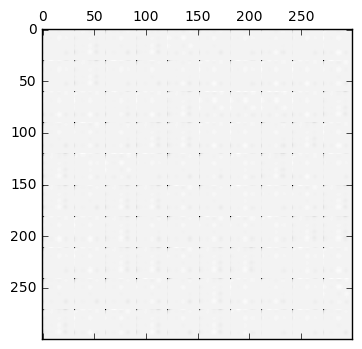

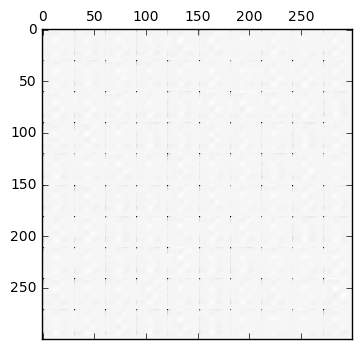

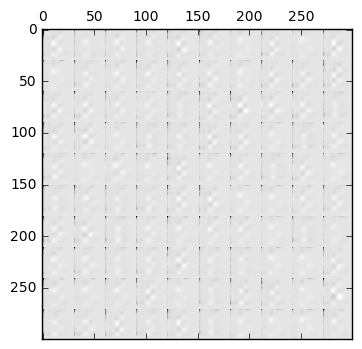

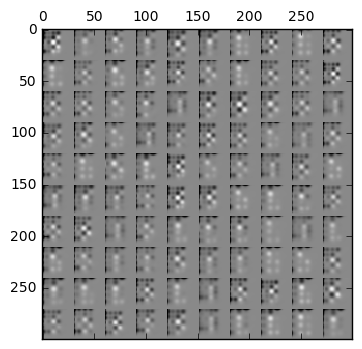

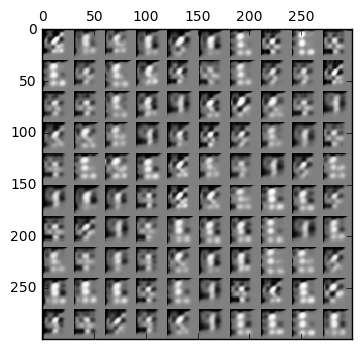

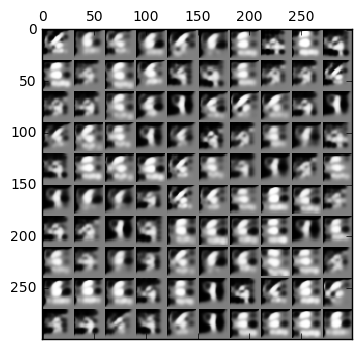

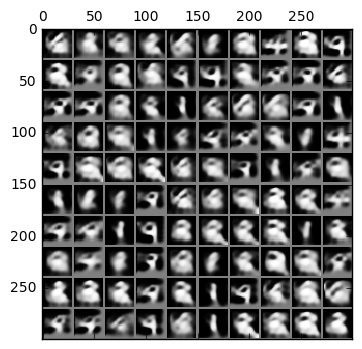

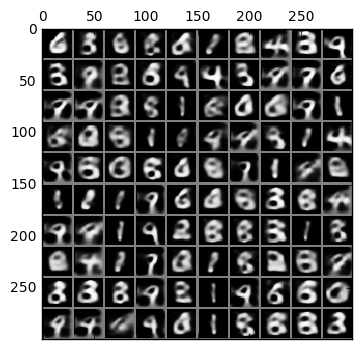

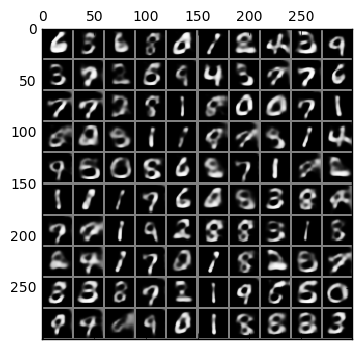

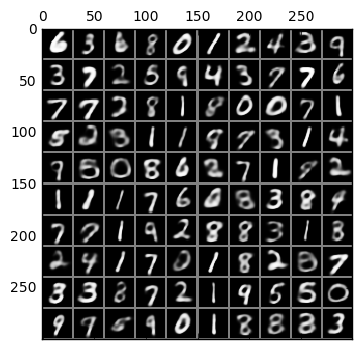

In [15]:
for t in range(T):
    img=xrecons_grid(X[t,:,:],B,A)
    plt.matshow(img,cmap=plt.cm.gray)
    ## convert -delay 10 -loop 0 *.png mnist.gif
    #imgname='img_%d.png' % ('images', t) 
    #plt.savefig(imgname)
    #print(imgname)
